# Data Import

In [127]:
import pandas as pd

In [128]:
train = pd.read_csv('./data/train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
test = pd.read_csv('./data/test.csv')
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
import numpy as np

In [131]:
from sklearn.model_selection import train_test_split

In [132]:
X_train = train.iloc[:,1:].values.reshape(-1, 1, 28, 28)
y_train = train.iloc[:,:1].values.flatten()
X_test = test.values.reshape(-1, 1, 28, 28)

In [133]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=3)

In [134]:
import matplotlib.pyplot as plt

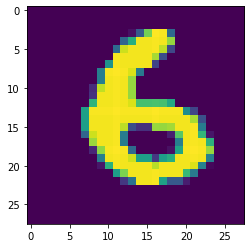

In [135]:
plt.imshow(X_train[5].reshape(28, 28, 1));

# Torch

In [136]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [137]:
augmentations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor()
])

In [138]:
class MnistData(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transforms = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            if self.transforms is not None:
                return self.transforms(self.X[idx]), self.y[idx]
            return self.X[idx], self.y[idx]
        if self.transforms is not None:
            return self.transforms(self.X[idx])
        return self.X[idx]

In [139]:
X_train = torch.tensor(X_train, dtype=torch.float32) / 255
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test, dtype=torch.float32) / 255

In [140]:
train_dataset = MnistData(X_train, y_train)
test_dataset = MnistData(X_test)
validation_dataset = MnistData(X_val, y_val)

In [141]:
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)
validation_loader = DataLoader(validation_dataset, batch_size=100)

In [142]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [143]:
epochs = 30
learning_rate = 0.001

In [144]:
class ConvBlock(nn.Module):
    def __init__(self, multiplyer, kernel_size):
        super().__init__()
        in_c = 1 if multiplyer == 1 else 32
        padding =  2 if multiplyer == 1 else 1
        self.conv1 = nn.Conv2d(in_c, 32*multiplyer, kernel_size, 1, padding)
        self.conv2 = nn.Conv2d(32*multiplyer, 32*multiplyer, kernel_size, 1, padding)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        return x

In [145]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(1, 5)
        self.convblock2 = ConvBlock(2, 3)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        out = self.fc1(x.flatten(1))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [146]:
model = CNN().to(device)

In [147]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.9)

In [148]:
n_total_steps = len(train_loader)

In [149]:
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch: [{epoch+1}/{epochs}], Step: [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch: [1/30], Step: [100/336], Loss: 0.1777
Epoch: [1/30], Step: [200/336], Loss: 0.1412
Epoch: [1/30], Step: [300/336], Loss: 0.0678
Epoch: [2/30], Step: [100/336], Loss: 0.0478
Epoch: [2/30], Step: [200/336], Loss: 0.1852
Epoch: [2/30], Step: [300/336], Loss: 0.0671
Epoch: [3/30], Step: [100/336], Loss: 0.0247
Epoch: [3/30], Step: [200/336], Loss: 0.1194
Epoch: [3/30], Step: [300/336], Loss: 0.0672
Epoch: [4/30], Step: [100/336], Loss: 0.0247
Epoch: [4/30], Step: [200/336], Loss: 0.1297
Epoch: [4/30], Step: [300/336], Loss: 0.1110
Epoch: [5/30], Step: [100/336], Loss: 0.0227
Epoch: [5/30], Step: [200/336], Loss: 0.0900
Epoch: [5/30], Step: [300/336], Loss: 0.0594
Epoch: [6/30], Step: [100/336], Loss: 0.0066
Epoch: [6/30], Step: [200/336], Loss: 0.0996
Epoch: [6/30], Step: [300/336], Loss: 0.0329
Epoch: [7/30], Step: [100/336], Loss: 0.0206
Epoch: [7/30], Step: [200/336], Loss: 0.0956
Epoch: [7/30], Step: [300/336], Loss: 0.0462
Epoch: [8/30], Step: [100/336], Loss: 0.0071
Epoch: [8/

In [150]:
def predict(data_load):
    test_pred = torch.LongTensor()

    for i, image in enumerate(data_load):
        image = image.to(device)

        output = model(image)

        pred = output.cpu().max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
    
    return test_pred

In [151]:
predictions = predict(test_loader)

In [152]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], predictions.numpy()], columns=['ImageId', 'Label'])

In [153]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [154]:
out_df.to_csv('submission.csv', index=False)

In [155]:
torch.save(model.state_dict(), 'model.pth')